# Integración de los datasets y análisis diferencial
### *Sheila Santomé*
--------

El flujo de trabajo de esta notebook consieste en la integración de los datasets de los dos ratones y el análisis de la expresión diferencial; para ellos, será necesario haber preprocesado antes los dos ratones por separado ejecutando el código de la libreta de *Preprocesado.ipynb*. 

## Importar paquetes

In [ ]:
import anndata
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scanpy as sc
import scvi
import seaborn as sns
from scipy.sparse import csr_matrix

## Cargar datos

A continuación, se procede a cargar los datos almacenados en objetos pickle que se obtienen tras haber preprocesado los datos; el nombre genérico de estos archivos es *counts_mouse_x_barcode_qc_metrics.pkl*.

In [ ]:

with open ("./pickles/counts_mouse_3_barcode_qcmetrics.pkl", 'rb') as f1 , \
    open ("./pickles/counts_mouse_1_barcode_qcmetrics.pkl", 'rb') as f2:
    
    counts_mouse_3 = pickle.load(f1)
    counts_mouse_1 = pickle.load(f2)


## Filtrado y unión de los datasets

Una vez cargados los datos, se decidió **filtrar las células de ambos ratones** según su **porcentaje de genes mitocondriales**, conservando únicamente aquellas con un valor menor al **15%**.Este paso permite **refinar la matriz de expresión**, eliminando células de baja calidad que podrían introducir ruido y asegurar que la información utilizada en los análisis posteriores sea **fiable**, especialmente al trabajar con un objeto que contiene **aproximadamente 20,000 células**.

Además, se añade una **columna al dataset** que indica a qué **muestra** pertenece cada célula. Esto es fundamental para poder **diferenciar las muestras** entre sí y realizar comparaciones precisas en análisis posteriores.

In [ ]:
counts_mouse_1 = counts_mouse_1[counts_mouse_1.obs.pct_counts_mt < 15]
counts_mouse_3 = counts_mouse_3[counts_mouse_3.obs.pct_counts_mt < 150]



In [ ]:
counts_mouse_1.obs["Sample"] = "Mouse_1"
counts_mouse_3.obs["Sample"] = "Mouse_3"


In [ ]:

counts_merged_mouse = counts_mouse_1.concatenate(counts_mouse_3, batch_key="Sample", batch_categories=["Mouse_1", "Mouse_3"])

# Comprobar cuantas células hay de cada muestra
counts_merged_mouse.obs["Sample"].value_counts()

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_12420\70133239.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  counts_merged_mouse = counts_mouse_1.concatenate(counts_mouse_3, batch_key="Sample", batch_categories=["Mouse_1", "Mouse_3"])


Sample
Mouse_3    14712
Mouse_1     3430
Name: count, dtype: int64

### Optimización y organización de la matriz de expresión

Al trabajar con un dataset bastante grande, se convierte la matriz de expresión `counts_merged_mouse.X` en una **matriz dispersa (`csr_matrix`)**, lo que permite reducir el uso de memoria y acelerar las operaciones posteriores. Además, se realiza un **conteo de células por muestra** mediante `counts_merged_mouse.obs.groupby('Sample').count()`, lo que permite verificar la distribución de células entre las muestras.

Para preservar los datos crudos, la matriz optimizada se copia a una nueva capa llamada **counts** dentro del objeto AnnData permitiendo tener disponibles los conteos originales para análisis posteriores y facilita trabajar de manera eficiente con la matriz principal transformada o normalizada.


In [ ]:
counts_merged_mouse.X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 36159164 stored elements and shape (18142, 15207)>

In [ ]:
counts_merged_mouse.X = csr_matrix(counts_merged_mouse.X)

In [ ]:
counts_merged_mouse.obs.groupby('Sample').count()


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_12420\501599177.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_merged_mouse.obs.groupby('Sample').count()


,doublet,barcode,condition,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
Sample,,,,,,,,,,,,,
Mouse_1,3430,2271,2185,3430,3430,3430,3430,3430,3430,3430,3430,3430,3430
Mouse_3,14712,12452,12213,14712,14712,14712,14712,14712,14712,14712,14712,14712,14712


In [ ]:
counts_merged_mouse.layers['counts'] = counts_merged_mouse.X.copy()

counts_merged_mouse.layers['counts']


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 36159164 stored elements and shape (18142, 15207)>

## Normalización, selección de genes y entrenamiento de SCVI

Primero, la matriz de expresión se normaliza por célula a un valor objetivo y se aplica una transformación logarítmica (`log1p`) para estabilizar la varianza de los genes de alta expresión. A continuación, se seleccionan los **5,000 genes más variables** usando el método *Seurat*, considerando las diferencias entre muestras, lo que permite centrar los análisis en los genes más informativos.

Luego, se configura el objeto AnnData para SCVI indicando la capa de conteos crudos y las covariables categóricas y continuas que podrían afectar la expresión génica. Se entrena un modelo SCVI con 10 dimensiones latentes durante 200 épocas, lo que permite capturar la **estructura latente de las células** y ajustar por covariables técnicas y biológicas, sirviendo como base para análisis posteriores como clustering y expresión diferencial corregida por batch.


In [ ]:
sc.pp.normalize_total(counts_merged_mouse, target_sum=1e4)
sc.pp.log1p(counts_merged_mouse)

sc.pp.highly_variable_genes(
    counts_merged_mouse,
    n_top_genes=5000,
    subset=True,
    flavor="seurat",
    batch_key="Sample"
)

In [ ]:
scvi.model.SCVI.setup_anndata(counts_merged_mouse, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                              continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
)

In [ ]:
model = scvi.model.SCVI(counts_merged_mouse, n_latent=10)
model.train(max_epochs=200)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 200/200: 100%|██████████| 200/200 [38:23<00:00,  6.22s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.45e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [38:23<00:00, 11.52s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.45e+3]


Como este modelo tarda bastante tiempo en ejecutarse, es preferible hacer una copia en caso de que se quiera repetir el análisis del *mismo* set de datos

In [ ]:
model_path = "./modelo_scvi_merged" #Cambiar de ser necesario
model.save(model_path, overwrite=True)  #De haber un modelo con el mismo nombre se sobreescribe, de no querer eso cambiar el overwrite a False


En caso de querer cargar el modelo se ejecutará el siguiente bloque de código.

In [ ]:
# Cargar modelo desde la carpeta guardada = 

model_path = "./modelo_scvi_merged"
model = scvi.model.SCVI.load(model_path, counts_merged_mouse)


INFO     File ./modelo_scvi_merged\model.pt already downloaded                                                     


## Clusterización

Una vez entrenado el modelo, se utiliza el método **`get_latents_representation`** para extraer la **representación latente** de cada célula. Esta proyección refleja el **espacio aprendido por SCVI**, en el que se han corregido los efectos de lote y reducido el ruido técnico.  

En este espacio de **menor dimensionalidad**, las células con perfiles de expresión similares tienden a agruparse de manera más clara, lo que facilita tanto la **visualización** como la **clusterización** posterior. Además, esta representación latente sirve como base para diversos análisis, incluyendo la **identificación de subpoblaciones celulares**, la **construcción de trayectorias celulares** y el **análisis de expresión diferencial** con mayor robustez.


In [ ]:
counts_merged_mouse.obsm['X_scVI'] = model.get_latent_representation()

In [ ]:
counts_merged_mouse.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

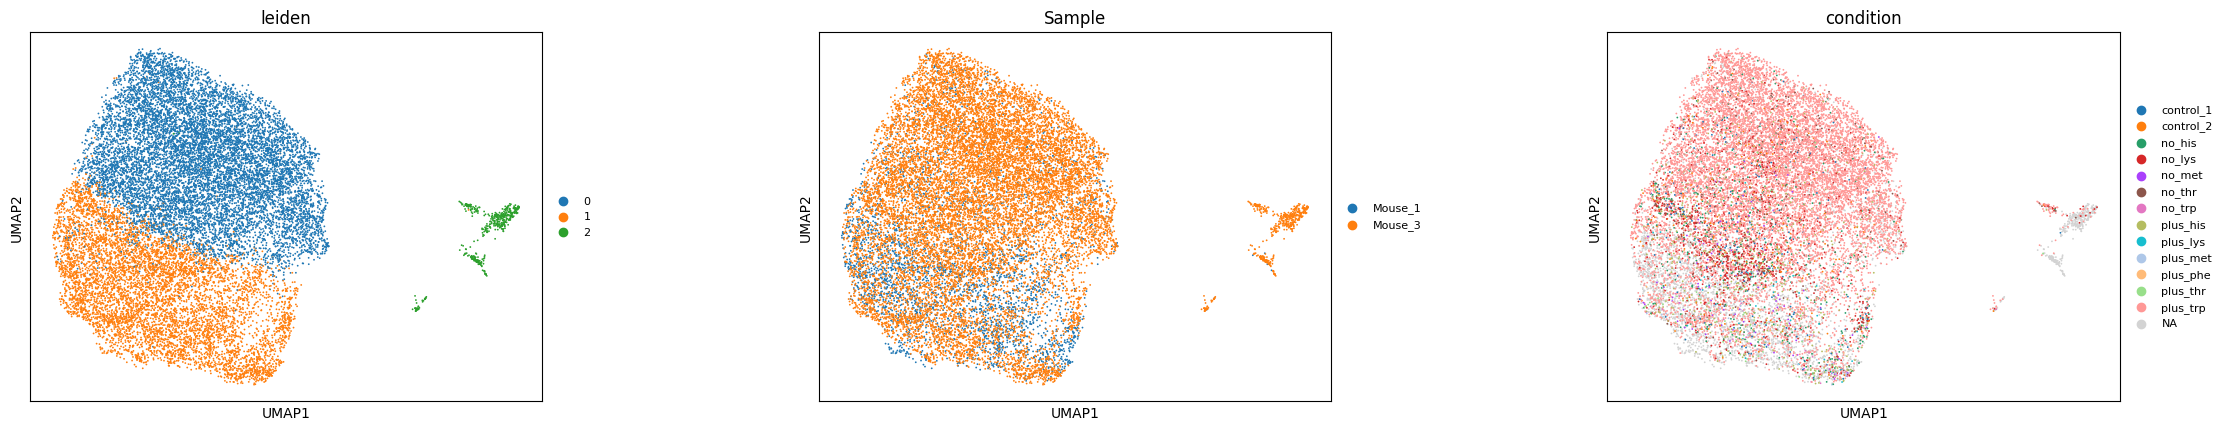

In [ ]:
sc.pp.neighbors(counts_merged_mouse, use_rep = 'X_scVI')

counts_merged_mouse.uns['neighbors_orig'] = counts_merged_mouse.uns['neighbors'].copy()

sc.tl.leiden(counts_merged_mouse, 
             resolution=0.3, #Este parámetro se puede modificar entre 0 y 1 
                            #dependiendendo de que tanto queramos sperar los clústers
             random_state=42)

sc.tl.umap(counts_merged_mouse, 
           min_dist=0.2, 
           spread=1.0, 
           random_state=42)

def plot_fixed_umap(adata, color_list):
    adata.uns['neighbors'] = adata.uns['neighbors_orig']
    
    sc.pl.umap(
        adata,
        color=color_list,
        legend_loc="right margin",
        legend_fontsize=8,
        wspace=0.4
    )


plot_fixed_umap(counts_merged_mouse, ['leiden', 'Sample', 'condition'])


El objeto `counts_merged_mouse` se guarda en formato **`.h5ad`** mediante `write_h5ad` en lugar de usar un **pickle**. El formato H5AD es el estándar de **Scanpy y AnnData**, diseñado específicamente para manejar matrices de expresión de células individuales de gran tamaño. 

In [ ]:
counts_merged_mouse.write_h5ad('integrated.h5ad')


## Análisis funcional
En esta sección se identificarán los **genes diferencialmente expresados (DEGs)** del dataset mediante el enfoque del **Cálculo de la expresión diferencial por SCVI** este método tiene en cuenta el **efecto de batch** y permite obtener estimaciones más robustas de la expresión diferencial.  

Para llevar a cabo estos análisis se emplea:
* **SCVI**:
    -  **`model.differential_expresion`** : calcula los genes diferencialmente expresados entre condiciones, considerando la corrección de batch y la estructura latente aprendida por el modelo.  

En este caso solo se va a buscar analizar los genes diferencialmente expresados en la condición de **plus_trp** en comparación con el resto de condiciones.

### Análisis de la expresión diferencial con SCVI

In [ ]:
# Diferential expression respecto a la condición
markers_condition = model.differential_expression(groupby='condition')

DE...: 100%|██████████| 13/13 [01:05<00:00,  5.02s/it]


In [ ]:
markers_condition

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
Osmr,0.7482,0.2518,1.089035,0.000129,0.000063,0.101322,0.061010,0.092511,0.051689,0.959367,0.511098,control_1 vs Rest,control_1,Rest
Dcn,0.7448,0.2552,1.071068,0.005403,0.002863,6.422907,3.691097,0.810573,0.709238,59.667211,31.018116,control_1 vs Rest,control_1,Rest
Lum,0.7428,0.2572,1.060573,0.000609,0.000197,0.202643,0.127714,0.074890,0.054368,2.066554,1.296185,control_1 vs Rest,control_1,Rest
Fbln5,0.7400,0.2600,1.045969,0.000210,0.000088,0.198238,0.073458,0.145374,0.061066,2.344684,0.721881,control_1 vs Rest,control_1,Rest
Col1a1,0.7392,0.2608,1.041815,0.000499,0.000241,0.352423,0.228635,0.167401,0.088362,3.203894,2.080680,control_1 vs Rest,control_1,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cyth1,0.2012,0.7988,-1.378811,0.000128,0.000245,0.197647,0.275764,0.146462,0.190979,1.208190,2.374632,plus_trp vs Rest,plus_trp,Rest
Pitpnc1,0.1998,0.8002,-1.387545,0.000193,0.000449,0.242636,0.419926,0.162536,0.243220,1.668874,4.027449,plus_trp vs Rest,plus_trp,Rest
Maml2,0.1992,0.8008,-1.391302,0.000237,0.000506,0.373114,0.621610,0.198096,0.286754,2.059919,4.905502,plus_trp vs Rest,plus_trp,Rest
Dennd1a,0.1986,0.8014,-1.395067,0.000324,0.000579,0.499461,0.672138,0.307202,0.371110,3.231172,6.049802,plus_trp vs Rest,plus_trp,Rest


A partir de estos resultados, los genes se filtran de la siguiente manera:

- **Genes ascendidos (up-regulated):** se seleccionan aquellos genes cuya expresión media es mayor en la condición `plus_trp` en comparación con las demás y que presentan suficiente evidencia estadística según el modelo (Bayes factor).  
- **Genes descendidos (down-regulated):** se seleccionan aquellos genes cuya expresión media es menor en `plus_trp` y que también cumplen criterios de significancia estadística.

#### **Genes Sobre expresados**:

In [ ]:
markers_plus_trp = markers_condition[
    (markers_condition['group1'] == 'plus_trp') &
    (markers_condition['group2'] == 'Rest')
]

markers_plus_trp

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
S100a10,0.8416,0.1584,1.670181,0.029160,0.009456,37.364853,12.241793,0.994343,0.904510,299.082223,101.687626,plus_trp vs Rest,plus_trp,Rest
Igfbp6,0.8384,0.1616,1.646371,0.002650,0.000972,3.032058,1.111048,0.801006,0.400942,24.511377,9.292443,plus_trp vs Rest,plus_trp,Rest
Lgals7,0.8338,0.1662,1.612802,0.005835,0.002024,6.580280,2.407508,0.870330,0.557237,54.603499,21.152983,plus_trp vs Rest,plus_trp,Rest
Lgals3,0.8276,0.1724,1.568713,0.012389,0.004860,15.109465,5.939623,0.974318,0.770625,122.933027,50.911221,plus_trp vs Rest,plus_trp,Rest
Mgp,0.8234,0.1766,1.539555,0.032267,0.014540,47.107220,19.625321,0.998204,0.969455,362.050181,164.874165,plus_trp vs Rest,plus_trp,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cyth1,0.2012,0.7988,-1.378811,0.000128,0.000245,0.197647,0.275764,0.146462,0.190979,1.208190,2.374632,plus_trp vs Rest,plus_trp,Rest
Pitpnc1,0.1998,0.8002,-1.387545,0.000193,0.000449,0.242636,0.419926,0.162536,0.243220,1.668874,4.027449,plus_trp vs Rest,plus_trp,Rest
Maml2,0.1992,0.8008,-1.391302,0.000237,0.000506,0.373114,0.621610,0.198096,0.286754,2.059919,4.905502,plus_trp vs Rest,plus_trp,Rest
Dennd1a,0.1986,0.8014,-1.395067,0.000324,0.000579,0.499461,0.672138,0.307202,0.371110,3.231172,6.049802,plus_trp vs Rest,plus_trp,Rest


In [ ]:
markers_plus_trp_up = markers_plus_trp[
    (markers_plus_trp['raw_mean1'] > markers_plus_trp['raw_mean2']) &
    (markers_plus_trp['bayes_factor'] > 1)  # evidencia estadística
]


markers_plus_trp_up


,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
S100a10,0.8416,0.1584,1.670181,0.029160,0.009456,37.364853,12.241793,0.994343,0.904510,299.082223,101.687626,plus_trp vs Rest,plus_trp,Rest
Igfbp6,0.8384,0.1616,1.646371,0.002650,0.000972,3.032058,1.111048,0.801006,0.400942,24.511377,9.292443,plus_trp vs Rest,plus_trp,Rest
Lgals7,0.8338,0.1662,1.612802,0.005835,0.002024,6.580280,2.407508,0.870330,0.557237,54.603499,21.152983,plus_trp vs Rest,plus_trp,Rest
Lgals3,0.8276,0.1724,1.568713,0.012389,0.004860,15.109465,5.939623,0.974318,0.770625,122.933027,50.911221,plus_trp vs Rest,plus_trp,Rest
Mgp,0.8234,0.1766,1.539555,0.032267,0.014540,47.107220,19.625321,0.998204,0.969455,362.050181,164.874165,plus_trp vs Rest,plus_trp,Rest
Akr1c18,0.8222,0.1778,1.531324,0.001570,0.000367,1.751527,0.402655,0.517241,0.160148,14.502113,3.255250,plus_trp vs Rest,plus_trp,Rest
Cryab,0.8218,0.1782,1.528590,0.001672,0.000471,1.927622,0.514987,0.599946,0.230802,15.808607,4.312787,plus_trp vs Rest,plus_trp,Rest
Hist1h2bc,0.8216,0.1784,1.527225,0.001466,0.000668,1.633172,0.687554,0.651221,0.335284,13.607298,6.257831,plus_trp vs Rest,plus_trp,Rest
Mt1,0.8134,0.1866,1.472256,0.026344,0.012605,38.025054,16.156580,0.997216,0.948330,284.745561,133.158197,plus_trp vs Rest,plus_trp,Rest
Bmp2,0.8094,0.1906,1.446116,0.002144,0.001018,2.785740,1.205253,0.746857,0.448187,20.763395,10.161113,plus_trp vs Rest,plus_trp,Rest


#### **Genes infra expresados**

In [ ]:
markers_plus_trp_down = markers_plus_trp[
    (markers_plus_trp['raw_mean1'] < markers_plus_trp['raw_mean2']) &
    (markers_plus_trp['bayes_factor'] < -1 )
]

markers_plus_trp_down


,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison,group1,group2
Aph1c,0.2688,0.7312,-1.000719,0.000020,0.000042,0.022719,0.028832,0.020923,0.027120,0.148480,0.277535,plus_trp vs Rest,plus_trp,Rest
Lama4,0.2686,0.7314,-1.001737,0.000038,0.000101,0.019217,0.067085,0.015984,0.052384,0.165245,0.749300,plus_trp vs Rest,plus_trp,Rest
Il17rd,0.2686,0.7314,-1.001737,0.000019,0.000044,0.015805,0.025407,0.014637,0.022695,0.121774,0.269981,plus_trp vs Rest,plus_trp,Rest
Angpt1,0.2686,0.7314,-1.001737,0.000021,0.000042,0.021013,0.027262,0.018588,0.022695,0.153596,0.233974,plus_trp vs Rest,plus_trp,Rest
Cpa6,0.2684,0.7316,-1.002755,0.000036,0.000079,0.015715,0.052098,0.012841,0.041679,0.099426,0.509385,plus_trp vs Rest,plus_trp,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Robo1,0.2014,0.7986,-1.377567,0.000015,0.000058,0.016613,0.049814,0.013649,0.036826,0.115263,0.470021,plus_trp vs Rest,plus_trp,Rest
Maml2,0.1958,0.8042,-1.412754,0.000233,0.000504,0.373114,0.621610,0.198096,0.286754,2.059919,4.905502,plus_trp vs Rest,plus_trp,Rest
Dennd1a,0.1928,0.8072,-1.431918,0.000321,0.000575,0.499461,0.672138,0.307202,0.371110,3.231172,6.049802,plus_trp vs Rest,plus_trp,Rest
Pitpnc1,0.1890,0.8110,-1.456521,0.000191,0.000450,0.242636,0.419926,0.162536,0.243220,1.668874,4.027449,plus_trp vs Rest,plus_trp,Rest


### *Análisis Funcional*
En esta sección se realiza un **análisis de enriquecimiento funcional** sobre los genes **diferencialemnte expresados** utilizando la herramienta *Enrichr* a través de `gseapy`. Primero, se extrae la lista de genes de interés y se define un conjunto de bases de datos funcionales (GO, KEGG, Reactome y Hallmark). Luego, se ejecuta el análisis de enriquecimiento de forma iterativa para cada *gene set*, recopilando y concatenando los términos funcionales obtenidos en un único dataframe. Finalmente, los resultados se ordenan según el *Adjusted P-value*, se exportan a un archivo CSV y se muestran para su posterior interpretación. 


#### Genes Infra expresados



In [ ]:
# Crear dataframe vacío para resultados
all_enrich_results_down = pd.DataFrame()

# Lista de genes down-regulados
genes_down = markers_plus_trp_down['names'].tolist()

# Lista de gene sets a consultar
gene_sets_list = [
    'GO_Biological_Process_2025',
    'KEGG_2019_Mouse',
    'Reactome_Pathways_2024',
    'MSigDB_Hallmark_2020'
]

# Bucle sobre cada gene set
for gene_set in gene_sets_list:
    enr = gp.enrichr(
        gene_list=genes_down,
        gene_sets=[gene_set],
        organism='Mouse',
        outdir='enrichr_down_results',
        cutoff=1.00
    )
    
    # Filtrar términos significativos
    significant_terms = enr.results
    
    # Concatenar al dataframe total
    all_enrich_results_down = pd.concat([all_enrich_results_down, significant_terms], ignore_index=True)

# Ordenar por Adjusted P-value
all_enrich_results_down = all_enrich_results_down.sort_values(by='Adjusted P-value')


In [ ]:
all_enrich_results_down = all_enrich_results_down.reset_index(drop=True)

# Exportar a CSV
all_enrich_results_down.to_csv("./Gen_Markers_Mouse/Condition/enrichr_down_trpvsrest_results.csv", sep = "\t", index=False)

all_enrich_results_down

#### Genes sobre expresados

In [ ]:
# Crear dataframe vacío para resultados
all_enrich_results_up = pd.DataFrame()

# Lista de genes up-regulados
genes_up = markers_plus_trp_up['names'].tolist()

# Lista de gene sets a consultar
gene_sets_list = [
    'GO_Biological_Process_2025',
    'KEGG_2019_Mouse',
    'Reactome_Pathways_2024',
    'MSigDB_Hallmark_2020'
]

# Ejecutar Enrichr en bucle
for gene_set in gene_sets_list:
    enr = gp.enrichr(
        gene_list=genes_up,
        gene_sets=[gene_set],
        organism='Mouse',
        outdir='enrichr_up_results',
        cutoff=1.0
    )

    # Filtrar términos significativos
    significant_terms = enr.results
    
    # Concatenar al dataframe total
    all_enrich_results_up = pd.concat([all_enrich_results_up, significant_terms], ignore_index=True)

# Ordenar por Adjusted P-value
all_enrich_results_up = all_enrich_results_up.sort_values(by='Adjusted P-value')

In [ ]:
all_enrich_results_up = all_enrich_results_up.reset_index(drop=True)

# Exportar a CSV
all_enrich_results_up.to_csv("./Gen_Markers_Mouse/Condition/enrichr_up_trpvsrest_results.csv", sep = "\t", index=False)

all_enrich_results_up

#### Guardar los genes diferencialmente expresados



In [ ]:
# Crear carpeta de salida si no existe
output_dir = "./Gen_Markers_Merged/SCVI" #Cambiar el path por el que se considere
os.makedirs(output_dir, exist_ok=True)

Para relacionar los genes diferencialmente expresados con sus **IDs de Ensembl**, se ha generado un archivo de referencia a partir de **[Ensembl BioMart](https://www.ensembl.org/biomart/martview/)**.  

El procedimiento es el siguiente:

1. **Database:** seleccionar **Ensembl Genes 115**.  
2. **Dataset:** seleccionar **Mouse genes (Mus musculus)**.  
3. **Atributos:** elegir únicamente las opciones **Gene Stable ID** y **Gene Name**.  
4. **Exportar resultados:** en formato **CSV**, que contendrá el listado completo de genes con sus identificadores.

Este archivo servirá como **referencia en múltiples notebooks**, por lo que permanecerá **constante** a lo largo de todos los análisis posteriores.  
Tener este archivo estandarizado facilita la **integración de resultados de expresión diferencial** con bases de datos externas, anotaciones biológicas y herramientas de análisis funcional como **[DAVID](https://davidbioinformatics.nih.gov/home.jsp)**.

In [ ]:
genes = pd.read_csv("./Gen_markers/gen_id.csv", sep=",")

In [ ]:
merged_up = pd.merge(
    markers_plus_trp_up,
    genes,
    left_on="names",
    right_on="Gene name",
    how="left"
    ).drop(columns=["Gene name"])

merged_down = pd.merge(
    markers_plus_trp_down,
    genes,
    left_on="names",
    right_on="Gene name",
    how="left"
    ).drop(columns=["Gene name"])

    # Guardar los resultados
merged_up.to_csv(
    f"{output_dir}/markers_merged_plus_trp_up.csv", #Cambiar nombre  según sea necesario
        sep="\t", index=False
    )
merged_down.to_csv(
        f"{output_dir}/markers_merged_plus_trp_down.csv", #Cambiar nombre  según sea necesario
        sep="\t", index=False
    )

#### Heatmap:
En esta sección se generan **heatmaps** que muestran los genes con mayor expresión diferencial en la condición plus_trp, comparándolo para cada condición experimental. Para ello, se emplea la función **`sc.pl.heatmap`** de Scanpy a la que le pasamos uan lista con los 20 genes más sobre expresados de la condición **plus_trp** y usando un mapa de colores **RdBu_r** para facilitar la comparación visual.

Primero se crea un heatmap contando todas las células de cada condición, pero como la mayoría de condiciones tienen pocas células en comparación con las células de la condición plus_trp; por lo que el heatmap, queda visualmente desvalanceado y no sepueden ver la mayoría de condiciónes. Por ello, se realiza un **submuestreo por grupo**, seleccionando un número equilibrado de células de cada condición. Con estas células balanceadas se genera un segundo heatmap, permitiendo comparar los patrones de expresión entre todas las condiciones. A mayores, se genera un tercer heatmap en el que se analiza como varía la expresión diferencial entre las células de ratón 1 y ratón 3.


c:\Python311\Lib\site-packages\anndata\_core\anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


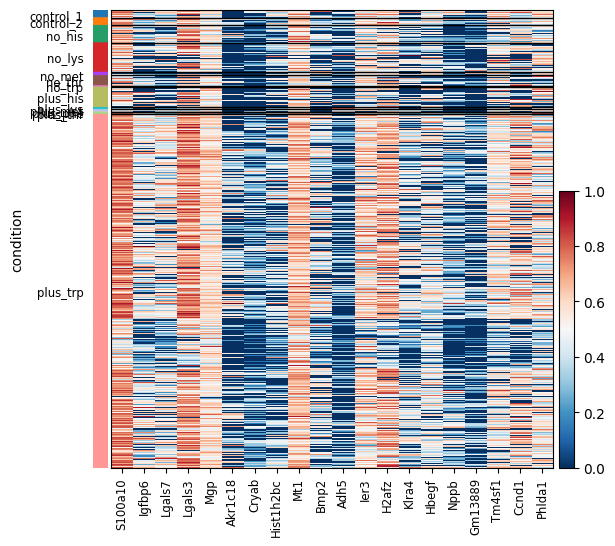

In [ ]:
adata_clean = counts_merged_mouse.copy()
adata_clean.obs['condition'] = adata_clean.obs['condition'].astype(str)
adata_clean = adata_clean[adata_clean.obs['condition'] != 'nan']


genes_heatmap = markers_plus_trp.index[markers_plus_trp['bayes_factor'].abs() > 1]
genes_heatmap = genes_heatmap[:20]  # limitar a 20 genes


sc.pl.heatmap(
    adata_clean,
    var_names=genes_heatmap,
    groupby='condition',
    use_raw=False,                 
    standard_scale='var',          
    cmap='RdBu_r',
    show=True,
    show_gene_labels=True
)




##### Con submuestreo por  condición y muestra


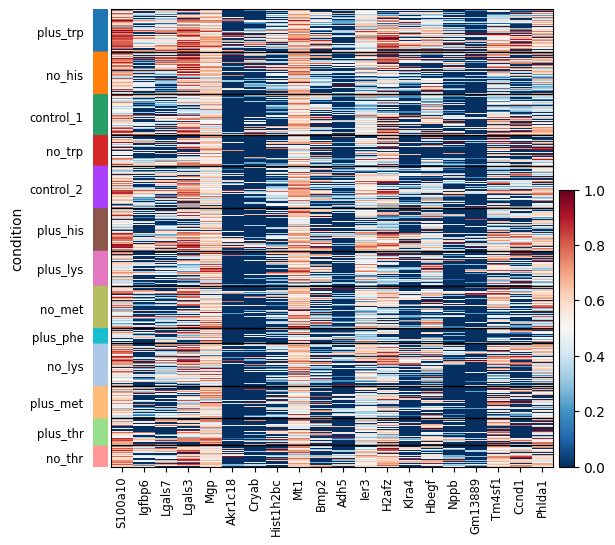

In [ ]:
n_cells = 25  # por condición y por muestra
indices = []

for sample in adata_clean.obs['Sample'].unique():
    for condition in adata_clean.obs['condition'].unique():
        group_indices = adata_clean.obs_names[
            (adata_clean.obs['Sample'] == sample) &
            (adata_clean.obs['condition'] == condition)
        ]
        if len(group_indices) > 0:
            sampled = np.random.choice(group_indices, size=min(n_cells, len(group_indices)), replace=False)
            indices.extend(sampled)

adata_balanced = adata_clean[indices].copy()

# Crear un orden nuevo
other_categories = [cat for cat in adata_balanced.obs['condition'].unique() if cat != 'plus_trp']

new_order = ['plus_trp'] + other_categories

adata_balanced.obs['condition'] = adata_balanced.obs['condition'].astype('category')
adata_balanced.obs['condition'] = adata_balanced.obs['condition'].cat.reorder_categories(new_order)

sc.pl.heatmap(
    adata_balanced,
    var_names=genes_heatmap,
    groupby='condition',
    use_raw=False,           # usar capa SCVI normalizada
    standard_scale='var',    # centrar y escalar por gen
    cmap='RdBu_r',
    show=True,
    show_gene_labels=True
)


#### Dividiendo los ratones

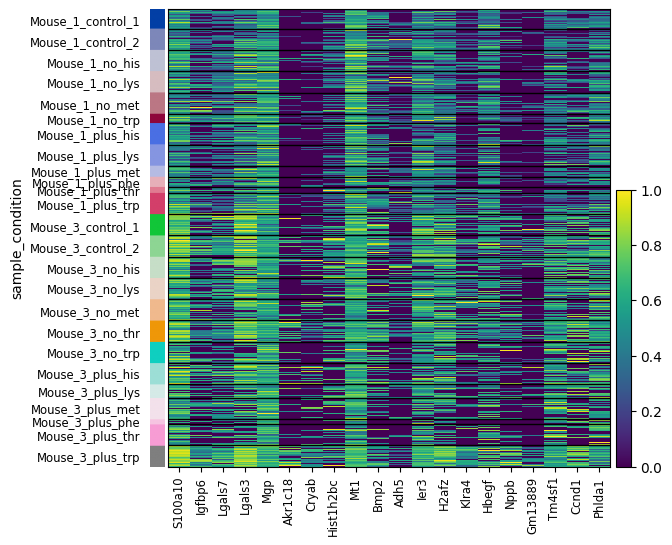

In [ ]:
adata_balanced.obs['sample_condition'] = (
    adata_balanced.obs['Sample'].astype(str) + "_" + adata_balanced.obs['condition'].astype(str))


sc.pl.heatmap(
    adata_balanced,
    var_names=genes_heatmap,
    groupby='sample_condition',
    standard_scale='var',
    cmap='viridis',
    show_gene_labels=True
)